In [1]:
###################
# Libs
###################

import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

from model_search import TSP_net

# visualization 
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


/tmp/ipykernel_2395293/337998046.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png2x','pdf')


In [2]:
###################
# Hardware : CPU / GPU(s)
###################

device = torch.device("cpu"); gpu_id = -1 # select CPU

gpu_id = '2' # select a single GPU  
# gpu_id = '2,3' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
# device = torch.device('cpu')
# print(device)


GPU name: NVIDIA RTX A6000, gpu_id: 2


# Hyperparameters

In [3]:
###################
# Hyper-parameters
###################

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self
        
args = DotDict()
args.gpu_id = gpu_id

args.segm_len = 5
args.embedding = 'linear'  # conv or linear
if args.embedding == 'conv':
    args.nb_neighbors = 10
    args.kernel_size = 11
elif args.embedding == 'linear':
    args.nb_neighbors = None
    args.kernel_size = None

args.dim_emb = 128
args.dim_ff = 512
args.dim_input_nodes = 2
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8
args.batchnorm = True  # if batchnorm=True  than batch norm is used
#args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 10000

print(args)

exp_name = 'tsp50_lin_m5'
# exp_name = '?'
checkpoint_file = f'checkpoint/{exp_name}.pkl'
B = 2500
greedy = True
beamsearch = True

{'gpu_id': '2', 'segm_len': 5, 'embedding': 'linear', 'nb_neighbors': None, 'kernel_size': None, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'batchnorm': True, 'max_len_PE': 10000}


# Instantiate, Load Model

In [5]:
#################
# WARNING: 
# TSPLIB HAS DIFFERENT 
# TOUR LENGTH COMPUTATION
################
# from utils import compute_tour_length
def compute_tour_length(x, tour, mode='EUC_2D'): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, nb_nodes, 2) batch of tsp tour instances
             tour of size (bsz, nb_nodes) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    if mode == 'EUC_2D':
        bsz = x.shape[0]
        nb_nodes = x.shape[1]
        arange_vec = torch.arange(bsz, device=x.device)
        first_cities = x[arange_vec, tour[:,0], :] # size(first_cities)=(bsz,2)
        previous_cities = first_cities
        L = torch.zeros(bsz, device=x.device)
        with torch.no_grad():
            for i in range(1,nb_nodes):
                current_cities = x[arange_vec, tour[:,i], :] 
                L += (current_cities - previous_cities).pow(2).sum(dim=1).sqrt().round()
                # L += torch.sum( torch.round((current_cities - previous_cities)**2) , dim=1 )**0.5 # dist(current, previous node) 
                previous_cities = current_cities
            L += (current_cities - first_cities).pow(2).sum(dim=1).sqrt().round()
            # L += torch.sum( torch.round((current_cities - first_cities)**2) , dim=1 )**0.5 # dist(last, first node)  
        return L
    else:
        raise NotImplementedError
        
        

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
###################
# Instantiate a training network and a baseline network
###################
try: 
    del model_baseline # remove existing model
except:
    pass

model_baseline = TSP_net(args.embedding, args.nb_neighbors, args.kernel_size,
                         args.dim_input_nodes, args.dim_emb, args.dim_ff, 
                         args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, args.max_len_PE,
                         segm_len=args.segm_len, batchnorm=args.batchnorm)

# uncomment these lines if trained with multiple GPUs
print(torch.cuda.device_count())
if torch.cuda.device_count()>1:
    model_baseline = nn.DataParallel(model_baseline)
# uncomment these lines if trained with multiple GPUs

model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')



###################
# Load checkpoint
###################
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
model_baseline.load_state_dict(checkpoint['model_baseline'])
print('Load checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
del checkpoint

mystring_min = 'Epoch: {:d}, tot_time_ckpt: {:.3f}day, L_train: {:.3f}, L_base: {:.3f}\n'.format(
    epoch_ckpt, tot_time_ckpt/3660/24, plot_performance_train[-1][1], plot_performance_baseline[-1][1]) 
print(mystring_min) 

1
{'gpu_id': '2', 'segm_len': 5, 'embedding': 'linear', 'nb_neighbors': None, 'kernel_size': None, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'batchnorm': True, 'max_len_PE': 10000}

Load checkpoint file=checkpoint/tsp50_lin_m5.pkl
  Checkpoint at epoch= 98 and time=2614.658min

Epoch: 99, tot_time_ckpt: 1.786day, L_train: 5.757, L_base: 5.758



# Prepare Data and Run Beamsearch

In [6]:
###################   
# Test set
###################
import pickle
with open('../datasets/tsplib.pkl', 'rb') as f:
    tsplib14 = pickle.load(f)
# keys = ['berlin52', 'rd100', 'eil101']
keys = tsplib14.keys()
whitelist = ['kroC100', 'att48', 'berlin52', 'kroA100', 'kroD100', 'ch150', 'ch130', 'gr96', 'rd100', 'gr120', 'st70', 'bays29', 'eil101', 'eil76', 'eil51']
blacklist = ['att48', 'bays29', 'gr96']
keys

dict_keys(['ulysses16', 'eil51', 'eil76', 'eil101', 'bays29', 'st70', 'rd100', 'gr96', 'ch130', 'ch150', 'kroA100', 'berlin52', 'att48', 'kroC100', 'kroD100', 'lin105', 'gr120', 'gr202', 'pa561', 'pcb442', 'pr76', 'pr1002', 'pr2392', 'tsp225'])

In [7]:

for key in whitelist:
    if key in blacklist:
        continue
    tsp_dict = tsplib14[key]
    metric = tsp_dict['type']
    ###################
    if metric != 'EUC_2D':
        continue
    ###################
    norm = lambda tensor: (tensor - tensor.min()) / (tensor.max() - tensor.min())

    x_org = torch.Tensor(tsp_dict['tsp']).to(device)[None,:]
    x = norm(x_org)
    tour = torch.LongTensor(tsp_dict['tour']).to(device)[None,:] - 1
    x_len = compute_tour_length(x_org, tour)
    # x_10k_len = compute_distance(x_10k_org, tour, metric)
    L_concorde = x_len.item()
    args.nb_nodes = tsp_dict['n']
    args.bsz = 1
    
    if args.nb_nodes < 30:
        B = 500
    elif args.nb_nodes < 50:
        B = 1500
    else:
        B = 2500
        

    ###################   
    # Run beam search
    ###################
    start = time.time()
    with torch.no_grad():
        tours_greedy, tours_beamsearch, scores_greedy, scores_beamsearch = model_baseline(x, B, greedy, beamsearch)
        # greedy
        if greedy:
            L_greedy = compute_tour_length(x_org, tours_greedy).item()
            gap_greedy = L_greedy / L_concorde - 1.0   
        # beamsearch
        if beamsearch:
            tours_beamsearch = tours_beamsearch.view(args.bsz*B, args.nb_nodes)
            x = x_org.repeat_interleave(B,dim=0)
            L_beamsearch = compute_tour_length(x, tours_beamsearch)
            tours_beamsearch = tours_beamsearch.view(args.bsz, B, args.nb_nodes)
            L_beamsearch = L_beamsearch.view(args.bsz, B)
            L_beamsearch_tmp = L_beamsearch
            L_beamsearch = L_beamsearch.min(dim=1)[0].item()
            gap_beamsearch = L_beamsearch / L_concorde - 1.0
    torch.cuda.empty_cache() # free GPU reserved memory 
    tot_time = time.time()-start
    
    
    ###################   
    # Write result file
    ###################
    csv_file = 'tsplib_results.csv'
    if not os.path.isfile(csv_file):
        print(f'File {csv_file} not found. Writing new file...')
        with open(csv_file, 'a') as f:
            head_str = ','.join(['model', 'problem', 'L_concorde', 'L_greedy', 'gap_greedy', 'L_beamsearch', 'gap_beamsearch', 'beam_width']) + '\n'
            f.write(head_str)
    metrics_str = list(map(str, [exp_name, key, L_concorde, L_greedy, 100*gap_greedy, L_beamsearch, 100*gap_beamsearch, B]))
    metrics_str = ','.join(metrics_str) + '\n'
    with open(csv_file, 'a') as f:
        f.write(metrics_str)
    

    if not os.path.isdir('test_res'):
        os.mkdir('test_res')
    file_name = os.path.join('test_res', 'tsplib.txt')
    with open(file_name, 'a', 1) as file:
        mystring = f'Model: {exp_name}, Problem: {key}, beam_width: {B}, L_concorde: {L_concorde}, L_greedy: {L_greedy}, gap_greedy: {100*gap_greedy}, L_beamsearch: {L_beamsearch}, gap_beamsearch: {100*gap_beamsearch}\n'
        print(mystring)
        file.write(mystring)

Model: tsp50_lin_m5, Problem: kroC100, beam_width: 2500, L_concorde: 20749.0, L_greedy: 21280.0, gap_greedy: 2.559159477565176, L_beamsearch: 21160.0, gap_beamsearch: 1.9808183526917045

Model: tsp50_lin_m5, Problem: berlin52, beam_width: 2500, L_concorde: 7542.0, L_greedy: 7604.0, gap_greedy: 0.8220631132325629, L_beamsearch: 7542.0, gap_beamsearch: 0.0

Model: tsp50_lin_m5, Problem: kroA100, beam_width: 2500, L_concorde: 21282.0, L_greedy: 22153.0, gap_greedy: 4.092660464242082, L_beamsearch: 21733.0, gap_beamsearch: 2.1191617329198387

Model: tsp50_lin_m5, Problem: kroD100, beam_width: 2500, L_concorde: 21294.0, L_greedy: 22437.0, gap_greedy: 5.36770921386307, L_beamsearch: 22139.0, gap_beamsearch: 3.9682539682539764

Model: tsp50_lin_m5, Problem: ch150, beam_width: 2500, L_concorde: 6528.0, L_greedy: 7160.0, gap_greedy: 9.681372549019617, L_beamsearch: 6936.0, gap_beamsearch: 6.25

Model: tsp50_lin_m5, Problem: ch130, beam_width: 2500, L_concorde: 6110.0, L_greedy: 6734.0, gap_gree

# Instance Check

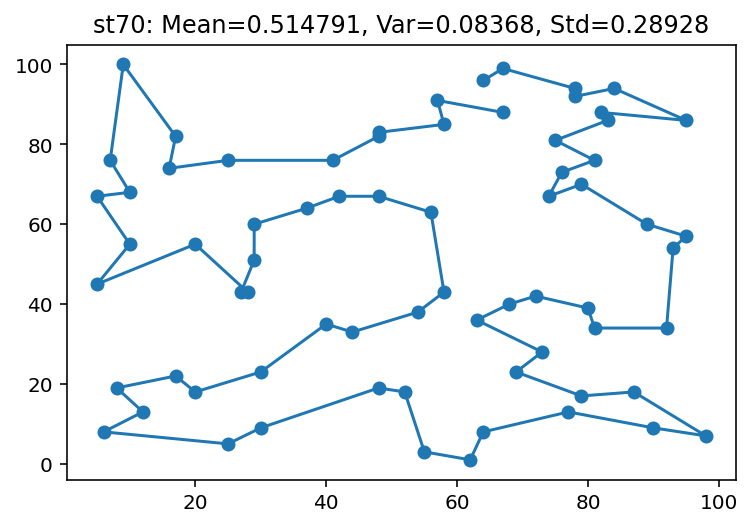

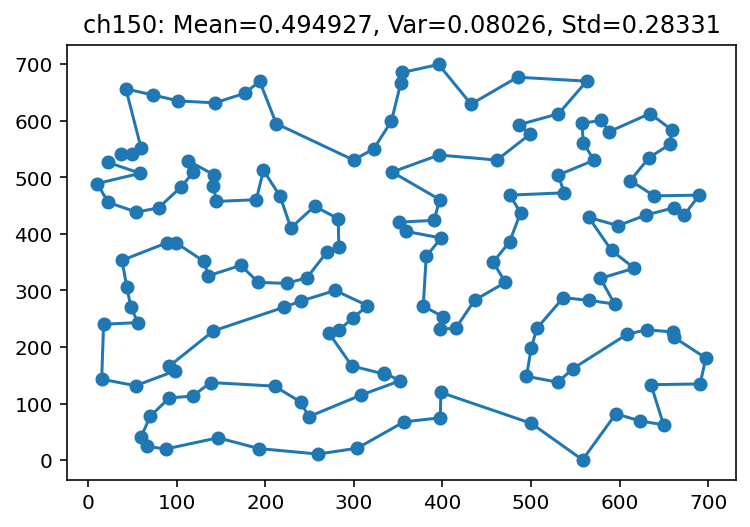

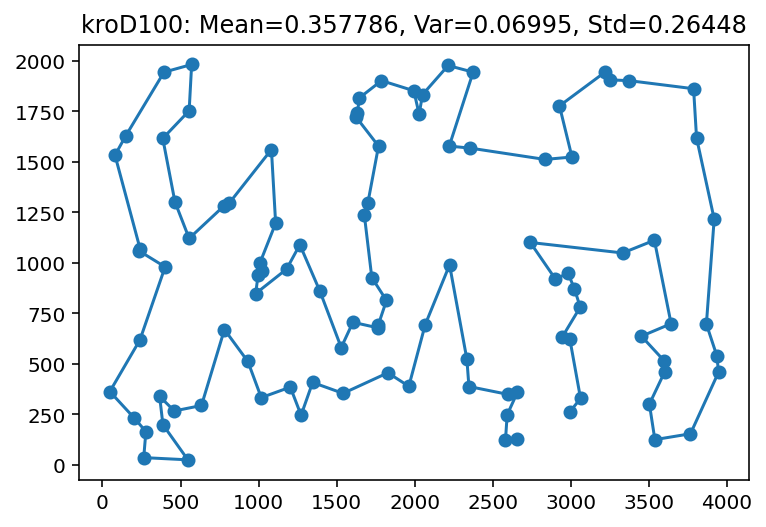

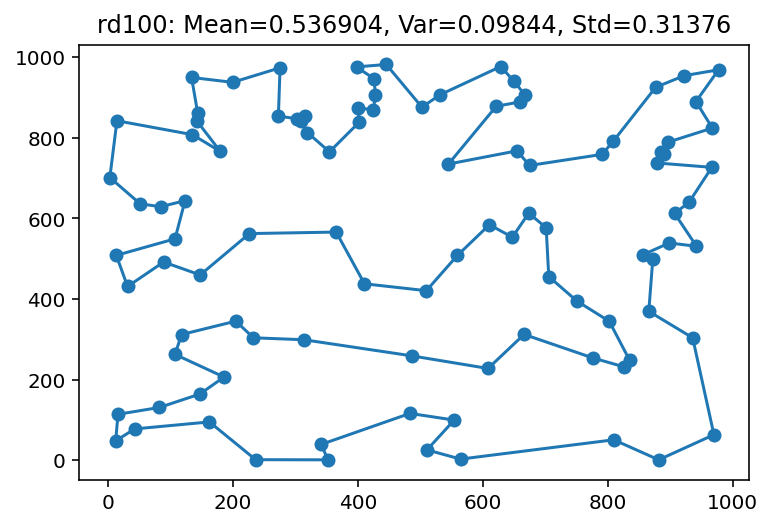

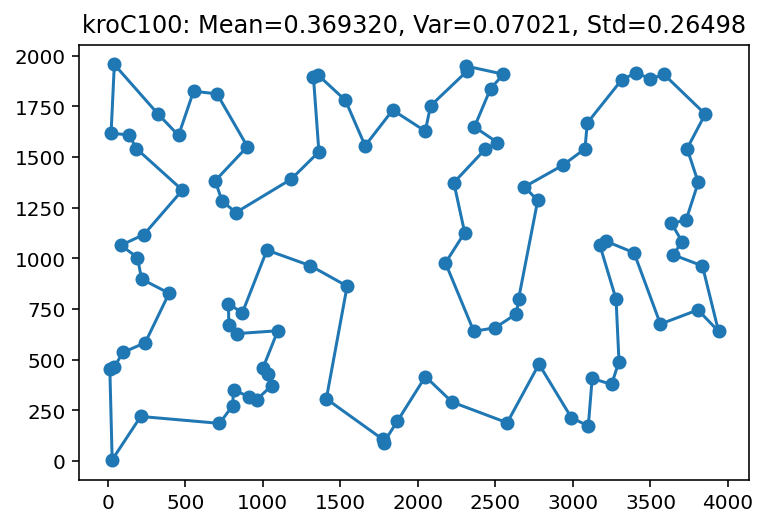

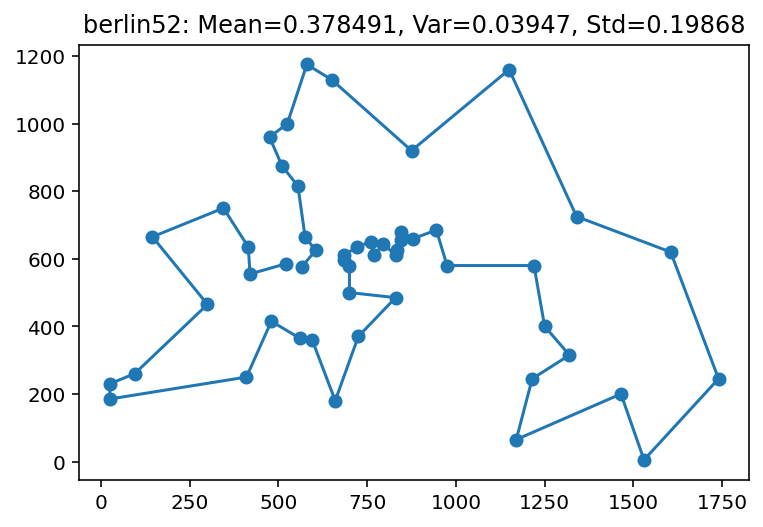

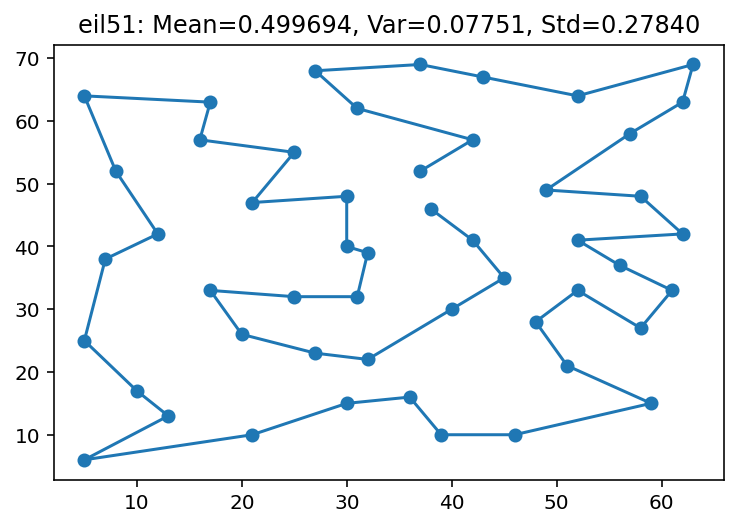

In [15]:
def foo(key):
    tmp_dic = tsplib14[key]
    tsp = np.array(tmp_dic['tsp'])
    opt_tour = np.array(tmp_dic['tour']) - 1
    plt.scatter(tsp[:,0], tsp[:,1])
    plt.plot(tsp[opt_tour,0], tsp[opt_tour,1])
    x = norm(tsp)
    plt.title(f'{key}: Mean={x.mean():5f}, Var={x.var():.5f}, Std={x.std():.5f}')
    plt.show()


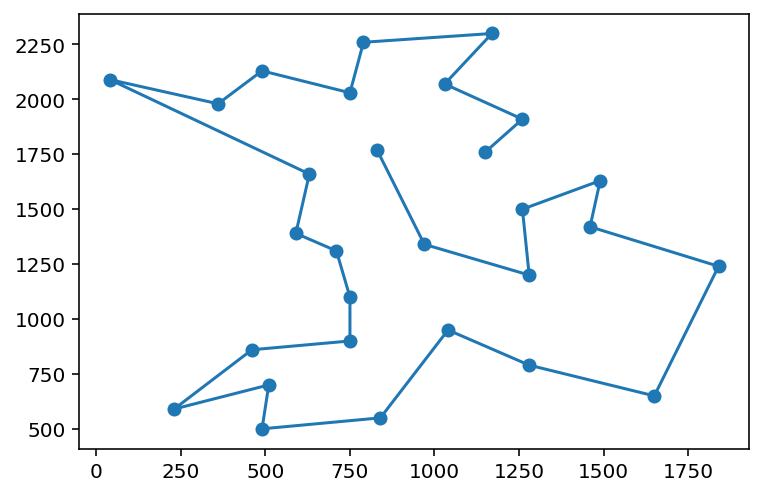

tensor([9290.])


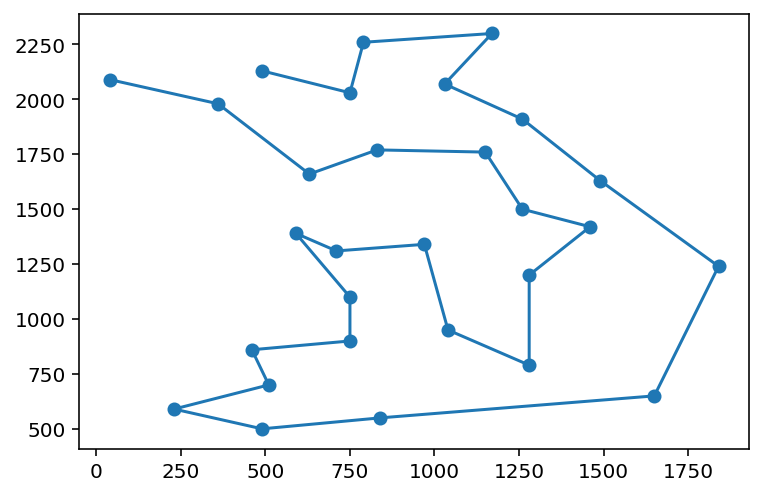

tensor([9725.])


In [ ]:
tmp_dic = tsplib14['bays29']
tsp = np.array(tmp_dic['tsp'])
opt_tour = np.array(tmp_dic['tour']) - 1
plt.scatter(tsp[:,0], tsp[:,1])
plt.plot(tsp[opt_tour,0], tsp[opt_tour,1])
plt.show()
print(compute_tour_length(torch.from_numpy(tsp)[None,:], torch.from_numpy(opt_tour)[None,:]))

x = norm(torch.from_numpy(tsp).to(device).float())[None,:]
pred_tour = model_baseline(x, greedy=True, B=1, beamsearch=False)[0].cpu().numpy()[0]
plt.scatter(tsp[:,0], tsp[:,1])
plt.plot(tsp[pred_tour,0], tsp[pred_tour,1])
plt.show()
print(compute_tour_length(torch.from_numpy(tsp)[None,:], torch.from_numpy(pred_tour)[None,:]))
# pred_tour.shape